In [7]:
# Import packages

import pandas as pd 
import numpy as np 
import os

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

import statsmodels.api as sm
from scipy import stats

from joblib import dump, load

pd.set_option('display.max_columns', None)

In [8]:
nfl = pd.read_csv('../../data/nfl_game_by_game_raw_stats.csv')

In [9]:
nfl.head()

,season,week,team,opponent,score,opponent_score,qb,total_pass_attempts,total_passing_yards,completions,passing_epa,pass_tds,air_yards,yards_after_catch,air_epa,yac_epa,avg_cpoe,total_rushes,total_rush_yards,rushing_epa,rush_tds,qb_epa,qb_rush_yards,qb_rushing_epa,qb_rush_tds,total_qb_rush_attempts,sacks_taken_qb,qb_hits_taken_qb,fumbles_qb,lost_fumbles_qb,interceptions_thrown_qb,sacks_allowed_team,qb_hits_allowed_team,fumbles_team,lost_fumbles_team,interceptions_thrown_team,total_rushes_allowed,total_rush_yards_allowed,rushing_epa_allowed,rush_tds_allowed,total_pass_attempts_allowed,passing_yards_allowed,completions_allowed,passing_epa_allowed,pass_tds_allowed,air_yards_allowed,yards_after_catch_allowed,air_epa_allowed,yac_epa_allowed,avg_cpoe_allowed,qb_epa_allowed,qb_rush_yards_allowed,qb_rushing_epa_allowed,qb_rush_tds_allowed,sacks,qb_hits,fumbles_forced,interceptions,fumbles_recovered,special_teams_epa,total_epa,total_opposing_epa
0,2014,1,ARI,LAC,18,17,C. Palmer,38,304.0,24.0,6.098425,2.0,196.0,108.0,10.800692,13.884696,3.160065,26,110.0,-7.697317,0.0,7.779734,30.0,1.681309,0.0,3.0,2.0,4.0,1.0,1.0,0.0,2.0,4.0,2.0,2.0,0.0,24,52.0,-8.805075,1.0,36,238.0,21.0,0.799435,1.0,148.0,90.0,8.328671,10.101167,-6.609174,-1.749010,10.0,-2.548446,0.0,0.0,4.0,0.0,1.0,0.0,-4.751772,1.654976,-1.654976
1,2014,1,ATL,NO,37,34,M. Ryan,42,448.0,31.0,17.253965,3.0,253.0,195.0,8.815695,16.383532,6.128030,25,123.0,2.559394,1.0,24.116820,15.0,0.272050,0.0,3.0,1.0,4.0,1.0,1.0,0.0,1.0,4.0,1.0,1.0,0.0,28,139.0,4.264254,3.0,42,333.0,29.0,9.202585,1.0,141.0,192.0,1.711281,22.435846,-0.291977,13.906331,2.0,-0.387024,0.0,0.0,0.0,1.0,1.0,1.0,-1.162613,5.183908,-5.183908
2,2014,1,BAL,CIN,16,23,J. Flacco,62,345.0,35.0,-4.871386,1.0,221.0,124.0,10.962930,14.313325,-11.889451,21,94.0,-0.093163,1.0,-3.078329,7.0,1.793058,0.0,3.0,3.0,6.0,0.0,0.0,1.0,3.0,6.0,1.0,1.0,1.0,24,81.0,-4.888501,0.0,39,303.0,25.0,11.252418,1.0,129.0,172.0,-3.613447,26.073280,-2.044220,7.354762,5.0,-3.897657,0.0,0.0,1.0,0.0,0.0,0.0,-2.107624,-13.436091,13.436091
3,2014,1,BUF,CHI,23,20,E. Manuel,22,173.0,16.0,0.368607,1.0,93.0,80.0,1.909633,9.530254,11.150598,31,197.0,4.315138,1.0,0.591515,23.0,0.222908,1.0,4.0,1.0,3.0,0.0,0.0,1.0,1.0,3.0,0.0,0.0,1.0,18,86.0,-0.055888,0.0,49,349.0,34.0,-6.755498,2.0,159.0,190.0,3.427141,16.035978,2.864331,0.058386,0.0,0.000000,0.0,2.0,4.0,1.0,2.0,1.0,3.721131,15.216262,-15.216262
4,2014,1,CAR,TB,20,14,D. Anderson,33,230.0,24.0,8.423189,2.0,160.0,70.0,6.298791,10.724494,9.822589,33,113.0,-6.247634,0.0,10.352312,10.0,1.929123,0.0,3.0,1.0,3.0,1.0,0.0,0.0,1.0,3.0,1.0,0.0,0.0,17,102.0,1.025410,0.0,35,183.0,22.0,-10.437735,2.0,138.0,45.0,6.082325,4.351872,0.519191,-3.645375,27.0,2.277812,0.0,3.0,9.0,2.0,2.0,1.0,-3.457676,8.130204,-8.130204


In [16]:
# Previous iteration tried to predict passing value using a modeling approach. The issue I found with this is that it 
# is difficult to create a label corresponding to a "good" quarterback game. In this approach, the focus will be 
# transforming the necessary features using scaling/normalization/etc. This approach should result in minimal changes
# to the actual value of the feature, just changing the representation.

In [17]:
# Get pass defense stats

pass_def = nfl.copy()
pass_def = pass_def[['season', 'week', 'team', 'opponent', 'score', 'opponent_score', 'total_pass_attempts_allowed', 'passing_yards_allowed',
        'completions_allowed', 'passing_epa_allowed', 'pass_tds_allowed', 'air_yards_allowed', 'yards_after_catch_allowed', 'air_epa_allowed', 'yac_epa_allowed', 'avg_cpoe_allowed',
        'qb_epa_allowed', 'qb_rush_yards_allowed', 'qb_rushing_epa_allowed', 'qb_rush_tds_allowed', 'sacks', 'qb_hits', 'fumbles_forced',
        'fumbles_recovered', 'interceptions']]
pass_def = pass_def.drop_duplicates()
pass_def

,season,week,team,opponent,score,opponent_score,total_pass_attempts_allowed,passing_yards_allowed,completions_allowed,passing_epa_allowed,pass_tds_allowed,air_yards_allowed,yards_after_catch_allowed,air_epa_allowed,yac_epa_allowed,avg_cpoe_allowed,qb_epa_allowed,qb_rush_yards_allowed,qb_rushing_epa_allowed,qb_rush_tds_allowed,sacks,qb_hits,fumbles_forced,fumbles_recovered,interceptions
0,2014,1,ARI,LAC,18,17,36,238.0,21.0,0.799435,1.0,148.0,90.0,8.328671,10.101167,-6.609174,-1.749010,10.0,-2.548446,0.0,0.0,4.0,0.0,0.0,1.0
1,2014,1,ATL,NO,37,34,42,333.0,29.0,9.202585,1.0,141.0,192.0,1.711281,22.435846,-0.291977,13.906331,2.0,-0.387024,0.0,0.0,0.0,1.0,1.0,1.0
2,2014,1,BAL,CIN,16,23,39,303.0,25.0,11.252418,1.0,129.0,172.0,-3.613447,26.073280,-2.044220,7.354762,5.0,-3.897657,0.0,0.0,1.0,0.0,0.0,0.0
3,2014,1,BUF,CHI,23,20,49,349.0,34.0,-6.755498,2.0,159.0,190.0,3.427141,16.035978,2.864331,0.058386,0.0,0.000000,0.0,2.0,4.0,1.0,1.0,2.0
4,2014,1,CAR,TB,20,14,35,183.0,22.0,-10.437735,2.0,138.0,45.0,6.082325,4.351872,0.519191,-3.645375,27.0,2.277812,0.0,3.0,9.0,2.0,1.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5864,2022,21,KC,CIN,23,20,41,270.0,26.0,-1.830367,1.0,151.0,119.0,6.690806,11.780224,8.062006,1.656690,30.0,3.487057,0.0,5.0,11.0,0.0,0.0,2.0
5865,2022,21,PHI,SF,31,7,18,97.0,11.0,-7.338993,0.0,31.0,66.0,-0.208252,5.490642,-0.534539,-11.930165,2.0,-4.591173,0.0,3.0,7.0,2.0,2.0,0.0
5866,2022,21,SF,PHI,7,31,25,121.0,15.0,-0.657053,0.0,71.0,50.0,0.958878,8.566836,-2.605077,0.835513,39.0,1.492567,1.0,1.0,2.0,0.0,0.0,0.0
5869,2022,22,KC,PHI,38,35,38,304.0,28.0,12.892024,1.0,222.0,117.0,9.827818,12.079392,14.972010,15.172346,72.0,2.280322,3.0,2.0,2.0,1.0,0.0,0.0


In [18]:
# Look at the distribution of passing epa. Should it be left as is? Scaled?

np.mean(pass_def.passing_epa_allowed)

0.9617669817792824

In [19]:
np.max(pass_def.passing_epa_allowed)

37.989697

In [20]:
np.min(pass_def.passing_epa_allowed)

-40.475357

In [21]:
best_pass_performances = pass_def.sort_values(by='passing_epa_allowed', ascending=False)
best_pass_performances.head(20)

,season,week,team,opponent,score,opponent_score,total_pass_attempts_allowed,passing_yards_allowed,completions_allowed,passing_epa_allowed,pass_tds_allowed,air_yards_allowed,yards_after_catch_allowed,air_epa_allowed,yac_epa_allowed,avg_cpoe_allowed,qb_epa_allowed,qb_rush_yards_allowed,qb_rushing_epa_allowed,qb_rush_tds_allowed,sacks,qb_hits,fumbles_forced,fumbles_recovered,interceptions
3184,2019,1,MIA,BAL,10,59,26,379.0,23.0,37.989697,6.0,218.0,161.0,14.612830,26.266829,28.640444,37.886658,17.0,-0.103038,0.0,1.0,1.0,0.0,0.0,0.0
268,2014,8,IND,PIT,34,51,49,522.0,40.0,36.206100,6.0,296.0,226.0,18.347322,23.776966,16.915632,40.139698,-1.0,-1.443085,0.0,0.0,0.0,2.0,2.0,0.0
2169,2017,9,GB,DET,17,30,33,361.0,26.0,33.548490,2.0,174.0,187.0,12.547172,24.192965,14.724008,30.984095,0.0,-2.564395,0.0,1.0,2.0,2.0,1.0,0.0
257,2014,8,CHI,NE,23,51,38,376.0,33.0,32.512577,5.0,213.0,163.0,21.966127,15.893890,20.737032,30.669910,0.0,-1.842666,0.0,1.0,1.0,0.0,0.0,0.0
4640,2021,5,IND,BAL,25,31,45,446.0,37.0,32.474290,4.0,267.0,175.0,15.857969,22.156212,17.772430,25.222906,62.0,-7.251381,0.0,2.0,4.0,1.0,1.0,0.0
5028,2021,16,BAL,CIN,21,41,46,525.0,37.0,32.462337,4.0,279.0,246.0,13.691797,31.177887,14.204991,34.681343,12.0,2.219006,0.0,3.0,6.0,0.0,0.0,0.0
4646,2021,5,MIA,TB,17,45,43,452.0,33.0,32.273087,5.0,214.0,238.0,4.560706,37.390137,15.150119,33.138477,13.0,0.865391,0.0,2.0,6.0,0.0,0.0,0.0
3310,2019,5,ATL,HOU,32,53,33,426.0,28.0,32.197030,5.0,222.0,204.0,15.549741,20.956861,17.858105,36.080143,47.0,3.883114,0.0,0.0,1.0,3.0,0.0,0.0
3398,2019,7,LV,GB,24,42,31,429.0,25.0,31.815393,5.0,206.0,223.0,8.283893,29.595753,20.738749,32.614830,6.0,0.799438,1.0,1.0,3.0,0.0,0.0,0.0
3877,2020,3,BAL,KC,20,34,42,385.0,31.0,31.377850,4.0,207.0,178.0,6.965472,32.178870,9.400512,35.252430,26.0,3.874581,1.0,0.0,4.0,1.0,1.0,0.0


In [22]:
worst_pass_performances = pass_def.sort_values(by='passing_epa_allowed', ascending=True)
worst_pass_performances.head(20)

,season,week,team,opponent,score,opponent_score,total_pass_attempts_allowed,passing_yards_allowed,completions_allowed,passing_epa_allowed,pass_tds_allowed,air_yards_allowed,yards_after_catch_allowed,air_epa_allowed,yac_epa_allowed,avg_cpoe_allowed,qb_epa_allowed,qb_rush_yards_allowed,qb_rushing_epa_allowed,qb_rush_tds_allowed,sacks,qb_hits,fumbles_forced,fumbles_recovered,interceptions
3222,2019,2,NE,MIA,43,0,39,186.0,18.0,-40.475357,0.0,125.0,61.0,-0.570181,9.589837,-16.102394,-39.694508,6.0,0.780851,0.0,7.0,11.0,0.0,0.0,4.0
2736,2018,7,DEN,ARI,45,10,39,194.0,21.0,-38.896610,1.0,122.0,72.0,1.744368,12.277300,-10.159547,-37.038696,14.0,1.857912,0.0,6.0,11.0,3.0,2.0,3.0
1816,2016,17,ARI,LA,44,6,28,143.0,17.0,-38.571790,0.0,20.0,123.0,-9.428609,13.428546,-11.436937,-34.950590,-1.0,-0.089809,0.0,7.0,8.0,4.0,1.0,2.0
1902,2017,1,JAX,HOU,29,7,36,164.0,19.0,-38.545410,1.0,99.0,65.0,2.213864,8.475595,-12.172345,-36.269028,16.0,2.276384,0.0,10.0,10.0,3.0,3.0,1.0
5072,2021,17,CHI,NYG,29,3,11,24.0,4.0,-35.564820,0.0,0.0,24.0,-3.608493,2.536155,-29.181055,-34.458668,13.0,1.106152,0.0,4.0,5.0,3.0,2.0,2.0
3338,2019,5,PHI,NYJ,31,6,27,120.0,15.0,-34.976100,0.0,38.0,82.0,-6.899850,12.142971,-7.548871,-34.976100,0.0,0.000000,0.0,10.0,16.0,2.0,1.0,2.0
4966,2021,14,DAL,WAS,27,20,35,175.0,15.0,-33.074337,1.0,92.0,83.0,-0.769879,5.063658,-17.442207,-27.771006,22.0,0.701971,0.0,5.0,9.0,3.0,3.0,1.0
2797,2018,9,CHI,BUF,41,9,50,188.0,31.0,-32.408330,0.0,64.0,124.0,-18.235290,16.831896,-5.480442,-21.058150,47.0,3.207608,1.0,4.0,9.0,1.0,1.0,3.0
437,2014,13,LA,LV,52,0,48,230.0,29.0,-32.219470,0.0,122.0,108.0,-5.489212,18.887900,-11.377539,-32.817547,1.0,-0.598075,0.0,6.0,7.0,3.0,2.0,3.0
3402,2019,7,NE,NYJ,33,0,32,86.0,11.0,-31.661474,0.0,67.0,19.0,1.590615,1.916720,-22.019503,-31.661474,0.0,0.000000,0.0,1.0,2.0,1.0,1.0,4.0


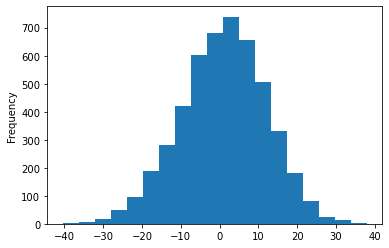

In [23]:
pass_def.passing_epa_allowed.plot.hist(bins=19)

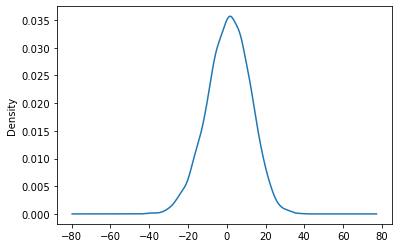

In [24]:
pass_def.passing_epa_allowed.plot.kde()

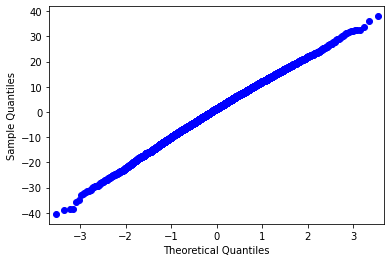

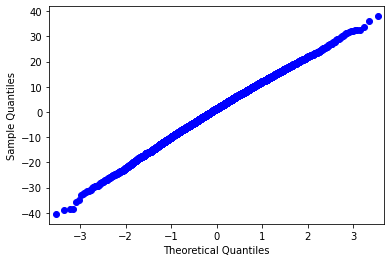

In [25]:
sm.qqplot(pass_def.passing_epa_allowed)

In [26]:
# Looks normal, creating a variable to normalize passing_epa

passing_epa_allowed_mean = np.mean(pass_def.passing_epa_allowed)
passing_epa_allowed_std = np.std(pass_def.passing_epa_allowed)
pass_def['passing_epa_allowed_standardized'] = pass_def.apply(lambda x: (x.passing_epa_allowed - passing_epa_allowed_mean)/passing_epa_allowed_std, axis=1)
pass_def.head()

,season,week,team,opponent,score,opponent_score,total_pass_attempts_allowed,passing_yards_allowed,completions_allowed,passing_epa_allowed,pass_tds_allowed,air_yards_allowed,yards_after_catch_allowed,air_epa_allowed,yac_epa_allowed,avg_cpoe_allowed,qb_epa_allowed,qb_rush_yards_allowed,qb_rushing_epa_allowed,qb_rush_tds_allowed,sacks,qb_hits,fumbles_forced,fumbles_recovered,interceptions,passing_epa_allowed_standardized
0,2014,1,ARI,LAC,18,17,36,238.0,21.0,0.799435,1.0,148.0,90.0,8.328671,10.101167,-6.609174,-1.749010,10.0,-2.548446,0.0,0.0,4.0,0.0,0.0,1.0,-0.014745
1,2014,1,ATL,NO,37,34,42,333.0,29.0,9.202585,1.0,141.0,192.0,1.711281,22.435846,-0.291977,13.906331,2.0,-0.387024,0.0,0.0,0.0,1.0,1.0,1.0,0.748551
2,2014,1,BAL,CIN,16,23,39,303.0,25.0,11.252418,1.0,129.0,172.0,-3.613447,26.073280,-2.044220,7.354762,5.0,-3.897657,0.0,0.0,1.0,0.0,0.0,0.0,0.934747
3,2014,1,BUF,CHI,23,20,49,349.0,34.0,-6.755498,2.0,159.0,190.0,3.427141,16.035978,2.864331,0.058386,0.0,0.000000,0.0,2.0,4.0,1.0,1.0,2.0,-0.700995
4,2014,1,CAR,TB,20,14,35,183.0,22.0,-10.437735,2.0,138.0,45.0,6.082325,4.351872,0.519191,-3.645375,27.0,2.277812,0.0,3.0,9.0,2.0,1.0,2.0,-1.035469


In [27]:
# Komolgorov smirnov test for normality

stats.kstest(pass_def.passing_epa_allowed_standardized, stats.norm.cdf)

KstestResult(statistic=0.015499307285190944, pvalue=0.18962842322574525)

In [28]:
# Want to also take a look at using passing epa per play

pass_def['passing_epa_per_attempt_allowed'] = pass_def.apply(lambda x: x.passing_epa_allowed/x.total_pass_attempts_allowed, axis=1)

In [29]:
# See best and worst performances

best_pass_performances_per_attempt = pass_def.sort_values(by='passing_epa_per_attempt_allowed', ascending=False)
best_pass_performances_per_attempt.head(20)

,season,week,team,opponent,score,opponent_score,total_pass_attempts_allowed,passing_yards_allowed,completions_allowed,passing_epa_allowed,pass_tds_allowed,air_yards_allowed,yards_after_catch_allowed,air_epa_allowed,yac_epa_allowed,avg_cpoe_allowed,qb_epa_allowed,qb_rush_yards_allowed,qb_rushing_epa_allowed,qb_rush_tds_allowed,sacks,qb_hits,fumbles_forced,fumbles_recovered,interceptions,passing_epa_allowed_standardized,passing_epa_per_attempt_allowed
3184,2019,1,MIA,BAL,10,59,26,379.0,23.0,37.989697,6.0,218.0,161.0,14.612830,26.266829,28.640444,37.886658,17.0,-0.103038,0.0,1.0,1.0,0.0,0.0,0.0,3.363416,1.461142
672,2015,1,TB,TEN,14,42,15,209.0,13.0,19.146578,4.0,103.0,106.0,13.125648,11.983685,21.860682,18.121532,6.0,-1.025045,0.0,2.0,2.0,2.0,1.0,0.0,1.651810,1.276439
549,2014,16,IND,DAL,7,42,21,261.0,19.0,26.702510,5.0,176.0,85.0,9.423650,20.765377,23.568323,29.929575,28.0,3.227063,0.0,1.0,1.0,1.0,1.0,0.0,2.338150,1.271548
2178,2017,9,NYG,LA,17,51,22,311.0,14.0,25.026323,4.0,137.0,165.0,9.630130,21.530264,1.410007,25.026323,0.0,0.000000,0.0,0.0,2.0,1.0,0.0,0.0,2.185894,1.137560
3560,2019,12,LA,BAL,6,45,23,208.0,16.0,24.339630,5.0,142.0,66.0,15.819777,17.342770,12.284083,29.777426,95.0,5.437795,0.0,3.0,7.0,0.0,0.0,0.0,2.123518,1.058245
597,2014,17,MIA,NYJ,24,37,27,396.0,21.0,28.441715,3.0,230.0,166.0,13.563077,22.503853,12.456202,24.249802,18.0,-4.191915,0.0,1.0,1.0,1.0,1.0,0.0,2.496130,1.053397
2539,2018,1,NO,TB,40,48,28,417.0,21.0,29.170437,4.0,287.0,130.0,24.376322,12.599808,12.812101,30.496738,39.0,1.326302,1.0,0.0,2.0,1.0,0.0,0.0,2.562323,1.041801
3398,2019,7,LV,GB,24,42,31,429.0,25.0,31.815393,5.0,206.0,223.0,8.283893,29.595753,20.738749,32.614830,6.0,0.799438,1.0,1.0,3.0,0.0,0.0,0.0,2.802576,1.026303
3631,2019,14,JAX,LAC,10,45,27,340.0,19.0,27.672037,4.0,111.0,229.0,4.199235,28.895180,11.918998,26.627127,12.0,-1.044911,0.0,1.0,7.0,0.0,0.0,0.0,2.426216,1.024890
212,2014,6,TB,BAL,17,48,27,306.0,21.0,27.500937,5.0,207.0,99.0,19.068624,12.264975,21.905886,27.500937,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,2.410674,1.018553


In [30]:
# See best and worst performances

worst_pass_performances_per_attempt = pass_def.sort_values(by='passing_epa_per_attempt_allowed', ascending=True)
worst_pass_performances_per_attempt.head(20)

,season,week,team,opponent,score,opponent_score,total_pass_attempts_allowed,passing_yards_allowed,completions_allowed,passing_epa_allowed,pass_tds_allowed,air_yards_allowed,yards_after_catch_allowed,air_epa_allowed,yac_epa_allowed,avg_cpoe_allowed,qb_epa_allowed,qb_rush_yards_allowed,qb_rushing_epa_allowed,qb_rush_tds_allowed,sacks,qb_hits,fumbles_forced,fumbles_recovered,interceptions,passing_epa_allowed_standardized,passing_epa_per_attempt_allowed
5072,2021,17,CHI,NYG,29,3,11,24.0,4.0,-35.564820,0.0,0.0,24.0,-3.608493,2.536155,-29.181055,-34.458668,13.0,1.106152,0.0,4.0,5.0,3.0,2.0,2.0,-3.317877,-3.233165
5048,2021,16,MIA,NO,20,3,20,135.0,12.0,-29.729810,0.0,54.0,81.0,-3.106783,8.236957,-7.278275,-28.710238,6.0,1.019573,0.0,8.0,11.0,0.0,0.0,2.0,-2.787856,-1.486490
1816,2016,17,ARI,LA,44,6,28,143.0,17.0,-38.571790,0.0,20.0,123.0,-9.428609,13.428546,-11.436937,-34.950590,-1.0,-0.089809,0.0,7.0,8.0,4.0,1.0,2.0,-3.591014,-1.377564
4589,2021,4,BUF,HOU,40,0,21,87.0,11.0,-28.334345,0.0,53.0,34.0,1.929766,-1.855153,-15.856213,-23.447777,2.0,-0.518641,0.0,3.0,3.0,1.0,1.0,4.0,-2.661100,-1.349255
4222,2020,12,NO,DEN,31,3,9,13.0,1.0,-11.930539,0.0,-3.0,16.0,-1.158506,2.899419,-36.172462,-12.915443,5.0,-0.984904,0.0,1.0,5.0,0.0,0.0,2.0,-1.171067,-1.325615
3338,2019,5,PHI,NYJ,31,6,27,120.0,15.0,-34.976100,0.0,38.0,82.0,-6.899850,12.142971,-7.548871,-34.976100,0.0,0.000000,0.0,10.0,16.0,2.0,1.0,2.0,-3.264401,-1.295411
5771,2022,17,DET,CHI,41,10,21,75.0,7.0,-26.995167,1.0,27.0,48.0,-3.479137,7.381964,-28.605930,-17.785082,132.0,9.210085,0.0,7.0,9.0,1.0,1.0,1.0,-2.539456,-1.285484
709,2015,3,ARI,SF,47,7,19,67.0,9.0,-23.920250,0.0,29.0,38.0,-2.928238,5.571064,-18.361101,-18.109222,46.0,5.811027,1.0,2.0,5.0,0.0,0.0,4.0,-2.260148,-1.258961
3051,2018,15,WAS,JAX,16,13,17,57.0,9.0,-21.317299,0.0,12.0,45.0,-6.286901,7.501678,-10.080374,-13.702970,68.0,7.614329,0.0,6.0,8.0,1.0,1.0,1.0,-2.023710,-1.253959
1904,2017,1,LA,IND,46,9,21,179.0,11.0,-25.545242,0.0,103.0,76.0,2.426553,3.841453,-7.657433,-20.840422,3.0,-0.361620,0.0,4.0,5.0,2.0,1.0,2.0,-2.407753,-1.216440


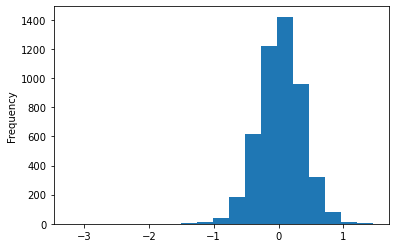

In [31]:
pass_def.passing_epa_per_attempt_allowed.plot.hist(bins=19)

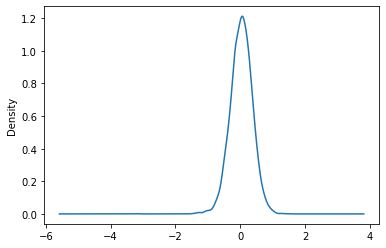

In [32]:
pass_def.passing_epa_per_attempt_allowed.plot.kde()

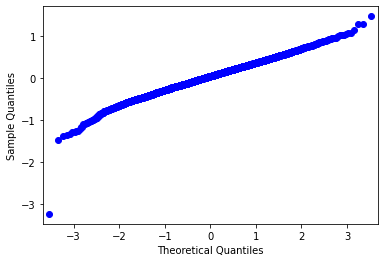

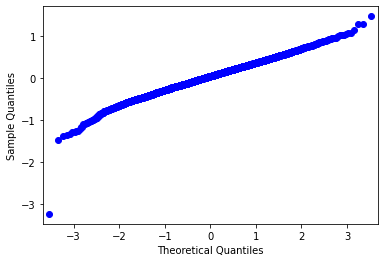

In [33]:
sm.qqplot(pass_def.passing_epa_per_attempt_allowed)

In [34]:
# Glennons performance was so bad, it may need to be removed as an outlier

In [35]:
np.mean(pass_def.passing_epa_per_attempt_allowed)

0.03082860688670514

In [36]:
np.std(pass_def.passing_epa_per_attempt_allowed)

0.338767595849157

In [37]:
passing_no_glennon = pass_def[pass_def.passing_epa_per_attempt_allowed >= -3]

In [38]:
np.mean(passing_no_glennon.passing_epa_per_attempt_allowed)

0.0314975952165744

In [39]:
np.std(passing_no_glennon.passing_epa_per_attempt_allowed)

0.33556368165165845

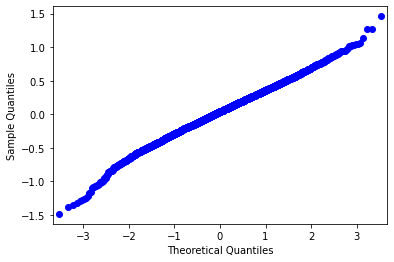

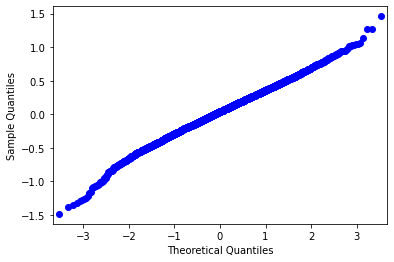

In [40]:
sm.qqplot(passing_no_glennon.passing_epa_per_attempt_allowed)

In [41]:
# Looks normal wihtout glennon, creating a variable to normalize passing_epa

passing_epa_paa_mean = np.mean(passing_no_glennon.passing_epa_per_attempt_allowed)
passing_epa_paa_std = np.std(passing_no_glennon.passing_epa_per_attempt_allowed)
pass_def['passing_epa_per_attempt_allowed_standardized'] = pass_def.apply(lambda x: (x.passing_epa_per_attempt_allowed - passing_epa_paa_mean)/passing_epa_paa_std, axis=1)
pass_def.head()

,season,week,team,opponent,score,opponent_score,total_pass_attempts_allowed,passing_yards_allowed,completions_allowed,passing_epa_allowed,pass_tds_allowed,air_yards_allowed,yards_after_catch_allowed,air_epa_allowed,yac_epa_allowed,avg_cpoe_allowed,qb_epa_allowed,qb_rush_yards_allowed,qb_rushing_epa_allowed,qb_rush_tds_allowed,sacks,qb_hits,fumbles_forced,fumbles_recovered,interceptions,passing_epa_allowed_standardized,passing_epa_per_attempt_allowed,passing_epa_per_attempt_allowed_standardized
0,2014,1,ARI,LAC,18,17,36,238.0,21.0,0.799435,1.0,148.0,90.0,8.328671,10.101167,-6.609174,-1.749010,10.0,-2.548446,0.0,0.0,4.0,0.0,0.0,1.0,-0.014745,0.022207,-0.027688
1,2014,1,ATL,NO,37,34,42,333.0,29.0,9.202585,1.0,141.0,192.0,1.711281,22.435846,-0.291977,13.906331,2.0,-0.387024,0.0,0.0,0.0,1.0,1.0,1.0,0.748551,0.219109,0.559094
2,2014,1,BAL,CIN,16,23,39,303.0,25.0,11.252418,1.0,129.0,172.0,-3.613447,26.073280,-2.044220,7.354762,5.0,-3.897657,0.0,0.0,1.0,0.0,0.0,0.0,0.934747,0.288524,0.765953
3,2014,1,BUF,CHI,23,20,49,349.0,34.0,-6.755498,2.0,159.0,190.0,3.427141,16.035978,2.864331,0.058386,0.0,0.000000,0.0,2.0,4.0,1.0,1.0,2.0,-0.700995,-0.137867,-0.504718
4,2014,1,CAR,TB,20,14,35,183.0,22.0,-10.437735,2.0,138.0,45.0,6.082325,4.351872,0.519191,-3.645375,27.0,2.277812,0.0,3.0,9.0,2.0,1.0,2.0,-1.035469,-0.298221,-0.982581


In [42]:
# Komolgorov smirnov test for normality

# Pretty sure this is approximately normal, KS test might be too sensitive

test_df = pass_def[np.abs(pass_def.passing_epa_per_attempt_allowed_standardized) < 3]
stats.kstest(test_df.passing_epa_per_attempt_allowed_standardized, stats.norm.cdf)

KstestResult(statistic=0.02053231426977334, pvalue=0.033151861384787096)

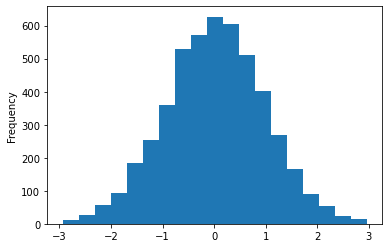

In [43]:
test_df.passing_epa_per_attempt_allowed_standardized.plot.hist(bins=19)

In [45]:
pass_def.sort_values(by='passing_epa_per_attempt_allowed_standardized', ascending=True)

,season,week,team,opponent,score,opponent_score,total_pass_attempts_allowed,passing_yards_allowed,completions_allowed,passing_epa_allowed,pass_tds_allowed,air_yards_allowed,yards_after_catch_allowed,air_epa_allowed,yac_epa_allowed,avg_cpoe_allowed,qb_epa_allowed,qb_rush_yards_allowed,qb_rushing_epa_allowed,qb_rush_tds_allowed,sacks,qb_hits,fumbles_forced,fumbles_recovered,interceptions,passing_epa_allowed_standardized,passing_epa_per_attempt_allowed,passing_epa_per_attempt_allowed_standardized
5072,2021,17,CHI,NYG,29,3,11,24.0,4.0,-35.564820,0.0,0.0,24.0,-3.608493,2.536155,-29.181055,-34.458668,13.0,1.106152,0.0,4.0,5.0,3.0,2.0,2.0,-3.317877,-3.233165,-9.728893
5048,2021,16,MIA,NO,20,3,20,135.0,12.0,-29.729810,0.0,54.0,81.0,-3.106783,8.236957,-7.278275,-28.710238,6.0,1.019573,0.0,8.0,11.0,0.0,0.0,2.0,-2.787856,-1.486490,-4.523696
1816,2016,17,ARI,LA,44,6,28,143.0,17.0,-38.571790,0.0,20.0,123.0,-9.428609,13.428546,-11.436937,-34.950590,-1.0,-0.089809,0.0,7.0,8.0,4.0,1.0,2.0,-3.591014,-1.377564,-4.199088
4589,2021,4,BUF,HOU,40,0,21,87.0,11.0,-28.334345,0.0,53.0,34.0,1.929766,-1.855153,-15.856213,-23.447777,2.0,-0.518641,0.0,3.0,3.0,1.0,1.0,4.0,-2.661100,-1.349255,-4.114725
4222,2020,12,NO,DEN,31,3,9,13.0,1.0,-11.930539,0.0,-3.0,16.0,-1.158506,2.899419,-36.172462,-12.915443,5.0,-0.984904,0.0,1.0,5.0,0.0,0.0,2.0,-1.171067,-1.325615,-4.044279
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3560,2019,12,LA,BAL,6,45,23,208.0,16.0,24.339630,5.0,142.0,66.0,15.819777,17.342770,12.284083,29.777426,95.0,5.437795,0.0,3.0,7.0,0.0,0.0,0.0,2.123518,1.058245,3.059769
2178,2017,9,NYG,LA,17,51,22,311.0,14.0,25.026323,4.0,137.0,165.0,9.630130,21.530264,1.410007,25.026323,0.0,0.000000,0.0,0.0,2.0,1.0,0.0,0.0,2.185894,1.137560,3.296133
549,2014,16,IND,DAL,7,42,21,261.0,19.0,26.702510,5.0,176.0,85.0,9.423650,20.765377,23.568323,29.929575,28.0,3.227063,0.0,1.0,1.0,1.0,1.0,0.0,2.338150,1.271548,3.695425
672,2015,1,TB,TEN,14,42,15,209.0,13.0,19.146578,4.0,103.0,106.0,13.125648,11.983685,21.860682,18.121532,6.0,-1.025045,0.0,2.0,2.0,2.0,1.0,0.0,1.651810,1.276439,3.709999


In [46]:
# Still not sure whats best. Per attempt gives higher praise for good games w few passes and penalized more heavily for
# bad games with fewer passes. Going to start with total, but may need to change this later.

passing_def_to_save = pass_def.copy()
passing_def_to_save['pass_def_value'] = passing_def_to_save.passing_epa_allowed_standardized
passing_def_to_save.head()

,season,week,team,opponent,score,opponent_score,total_pass_attempts_allowed,passing_yards_allowed,completions_allowed,passing_epa_allowed,pass_tds_allowed,air_yards_allowed,yards_after_catch_allowed,air_epa_allowed,yac_epa_allowed,avg_cpoe_allowed,qb_epa_allowed,qb_rush_yards_allowed,qb_rushing_epa_allowed,qb_rush_tds_allowed,sacks,qb_hits,fumbles_forced,fumbles_recovered,interceptions,passing_epa_allowed_standardized,passing_epa_per_attempt_allowed,passing_epa_per_attempt_allowed_standardized,pass_def_value
0,2014,1,ARI,LAC,18,17,36,238.0,21.0,0.799435,1.0,148.0,90.0,8.328671,10.101167,-6.609174,-1.749010,10.0,-2.548446,0.0,0.0,4.0,0.0,0.0,1.0,-0.014745,0.022207,-0.027688,-0.014745
1,2014,1,ATL,NO,37,34,42,333.0,29.0,9.202585,1.0,141.0,192.0,1.711281,22.435846,-0.291977,13.906331,2.0,-0.387024,0.0,0.0,0.0,1.0,1.0,1.0,0.748551,0.219109,0.559094,0.748551
2,2014,1,BAL,CIN,16,23,39,303.0,25.0,11.252418,1.0,129.0,172.0,-3.613447,26.073280,-2.044220,7.354762,5.0,-3.897657,0.0,0.0,1.0,0.0,0.0,0.0,0.934747,0.288524,0.765953,0.934747
3,2014,1,BUF,CHI,23,20,49,349.0,34.0,-6.755498,2.0,159.0,190.0,3.427141,16.035978,2.864331,0.058386,0.0,0.000000,0.0,2.0,4.0,1.0,1.0,2.0,-0.700995,-0.137867,-0.504718,-0.700995
4,2014,1,CAR,TB,20,14,35,183.0,22.0,-10.437735,2.0,138.0,45.0,6.082325,4.351872,0.519191,-3.645375,27.0,2.277812,0.0,3.0,9.0,2.0,1.0,2.0,-1.035469,-0.298221,-0.982581,-1.035469


In [47]:
passing_def_to_save.to_csv('passing_defense_value_model_v2_data/pass_def_with_value.csv')

In [48]:
# Look at best/worst def by passing epa standardized

pdef = pass_def.groupby(by=['team']).agg({'passing_epa_allowed_standardized': 'mean', 'week':'count'}).reset_index()
pdef

,team,passing_epa_allowed_standardized,week
0,ARI,-0.073415,150
1,ATL,0.255287,151
2,BAL,-0.097382,153
3,BUF,-0.251117,154
4,CAR,-0.062353,152
5,CHI,0.060299,148
6,CIN,0.007133,154
7,CLE,0.082792,148
8,DAL,-0.062199,154
9,DEN,-0.264669,150


In [50]:
pdef.sort_values(by='passing_epa_allowed_standardized', ascending = True).head(20)

,team,passing_epa_allowed_standardized,week
9,DEN,-0.264669,150
3,BUF,-0.251117,154
21,NE,-0.229029,162
16,LA,-0.196320,156
20,MIN,-0.194425,152
15,KC,-0.113654,164
2,BAL,-0.097382,153
25,PHI,-0.088422,156
26,PIT,-0.084293,155
0,ARI,-0.073415,150


In [53]:
pdef.sort_values(by='passing_epa_allowed_standardized', ascending = False).head(20)

,team,passing_epa_allowed_standardized,week
18,LV,0.363961,148
10,DET,0.259842,148
1,ATL,0.255287,151
30,TEN,0.169858,153
24,NYJ,0.162148,146
23,NYG,0.127930,149
31,WAS,0.112502,148
19,MIA,0.098724,148
7,CLE,0.082792,148
14,JAX,0.068498,151


In [54]:
pdef2 = pass_def.groupby(by=['team', 'season']).agg({'passing_epa_allowed_standardized': 'mean', 'week':'count'}).reset_index()
pdef2

,team,season,passing_epa_allowed_standardized,week
0,ARI,2014,-0.251543,17
1,ARI,2015,-0.238020,18
2,ARI,2016,-0.324358,16
3,ARI,2017,-0.318394,16
4,ARI,2018,-0.054484,16
...,...,...,...,...
283,WAS,2018,-0.007183,16
284,WAS,2019,0.459282,16
285,WAS,2020,-0.346566,17
286,WAS,2021,0.358627,17


In [55]:
pdef2.sort_values(by='passing_epa_allowed_standardized', ascending = False).head(20)

,team,season,passing_epa_allowed_standardized,week
96,DET,2020,0.901962,16
199,NO,2015,0.872955,16
114,HOU,2020,0.706646,16
65,CLE,2016,0.685350,16
176,MIA,2019,0.681829,16
5,ARI,2019,0.651800,16
223,NYJ,2021,0.633004,17
92,DET,2016,0.628376,17
279,WAS,2014,0.620210,16
132,JAX,2020,0.614774,16


In [56]:
pdef2.sort_values(by='passing_epa_allowed_standardized', ascending = True).head(20)

,team,season,passing_epa_allowed_standardized,week
194,NE,2019,-1.009341,17
83,DEN,2016,-0.877711,16
129,JAX,2017,-0.779806,19
82,DEN,2015,-0.730983,19
37,CAR,2015,-0.716310,19
150,LA,2020,-0.685598,18
21,BAL,2017,-0.644804,16
108,HOU,2014,-0.628219,16
257,SF,2019,-0.601731,19
79,DAL,2021,-0.588675,18
